## Introduction

This was modified from https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb 

## Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [193]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = "octopus2" # Replace with your own bucket name if needed
print(bucket)
prefix = 'blazingtext' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::327462831702:role/service-role/AmazonSageMaker-ExecutionRole-20191230T202701
octopus2


### Data Preparation

We have already prepared the training and validation datasets in the format specified here: https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html 

The datasets were processed using the notebook: BlazingTextDataPrepTrainEval.ipynb

The datasets are now in:
1. ``s3://octopus2/blazingtext/jira_largeset_test.lst``
2. ``s3://octopus2/blazingtext/jira_largeset_train.lst``

In [194]:
train_channel = prefix + '/jira_largeset_train.lst'
validation_channel = prefix + '/jira_largeset_test.lst'

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

In [195]:
## Set up output locations
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [196]:
region_name = boto3.Session().region_name

In [197]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


## Training the BlazingText model for supervised text classification

Similar to the original implementation of [Word2Vec](https://arxiv.org/pdf/1301.3781.pdf), SageMaker BlazingText provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures using Negative Sampling, on CPUs and additionally on GPU[s]. The GPU implementation uses highly optimized CUDA kernels. To learn more, please refer to [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354).




Besides skip-gram and CBOW, SageMaker BlazingText also supports the "Batch Skipgram" mode, which uses efficient mini-batching and matrix-matrix operations ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)). This mode enables distributed word2vec training across multiple CPU nodes, allowing almost linear scale up of word2vec computation to process hundreds of millions of words per second. Please refer to [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf) to learn more.

BlazingText also supports a *supervised* mode for text classification. It extends the FastText text classifier to leverage GPU acceleration using custom CUDA kernels. The model can be trained on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. For more information, please refer to the [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html).

To summarize, the following modes are supported by BlazingText on different types instances:

|          Modes         	| cbow (supports subwords training) 	| skipgram (supports subwords training) 	| batch_skipgram 	| supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:	| :--------------:	|
|   Single CPU instance  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   Single GPU instance  	|   ✔  	|     ✔    	|                	|  ✔ (Instance with 1 GPU only)  |
| Multiple CPU instances 	|      	|          	|        ✔       	|     | |

Now, let's define the SageMaker `Estimator` with resource configurations and hyperparameters to train Text Classification on *DBPedia* dataset, using "supervised" mode on a `c4.4xlarge` instance.


In [198]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Please refer to [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) for the complete list of hyperparameters.

In [199]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=20,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=100,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [200]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

We have our `Estimator` object, we have set the hyper-parameters for this object and we have our data channels linked with the algorithm. The only  remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the `Estimator` classes is provisioned and is setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out Accuracy on the validation data for every epoch after training job has executed `min_epochs`. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [201]:
bt_model.fit(inputs=data_channels, logs=True)

2020-07-04 23:58:41 Starting - Starting the training job...
2020-07-04 23:58:44 Starting - Launching requested ML instances......
2020-07-04 23:59:59 Starting - Preparing the instances for training......
2020-07-05 00:01:09 Downloading - Downloading input data
2020-07-05 00:01:09 Training - Downloading the training image..Arguments: train
[07/05/2020 00:01:25 WARNING 140115134285632] Loggers have already been setup.
[07/05/2020 00:01:25 WARNING 140115134285632] Loggers have already been setup.
[07/05/2020 00:01:25 INFO 140115134285632] nvidia-smi took: 0.0252480506897 secs to identify 0 gpus
[07/05/2020 00:01:25 INFO 140115134285632] Running single machine CPU BlazingText training using supervised mode.
[07/05/2020 00:01:25 INFO 140115134285632] Processing /opt/ml/input/data/train/jira_largeset_train.lst . File size: 13 MB
[07/05/2020 00:01:25 INFO 140115134285632] Processing /opt/ml/input/data/validation/jira_largeset_test.lst . File size: 5 MB
Read 1M words
Number of words:  43936

2

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [202]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

---------------!

#### Use JSON format for inference
BlazingText supports `application/json` as the content-type for inference. The payload should contain a list of sentences with the key as "**instances**" while being passed to the endpoint.

In [203]:
# Note: first should be classified as label4, second should be 6
sentences = ["Mobile Button label truncated at  % scale Steps to reproduce: . Run the attached mobile program on desktop . Observe the small button, whose label is truncated. Button is inside a Group with scaleX and scaleY of  . . . Click the \"Bigger\" button, which makes the small button wider . Observe that the small button label is still truncated even though there is plenty of room for the whole label  Actual Results:   Expected Results: Small button label should not be truncated at step   or step    Workaround (if any):",
            "compiler error when compiling the app model with asc.jar d : error: Attempt to delete the fixed property This bug was imported from another system and requires review from a project committer before some of the details can be marked public. For more information about historical bugs, please read: [Why are some bugs missing information?| "]

# using the same nltk tokenizer that we used during data preparation for training
#tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances" : sentences}

response = text_classifier.predict(json.dumps(payload))
print(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

{"instances": ["Mobile Button label truncated at  % scale Steps to reproduce: . Run the attached mobile program on desktop . Observe the small button, whose label is truncated. Button is inside a Group with scaleX and scaleY of  . . . Click the \"Bigger\" button, which makes the small button wider . Observe that the small button label is still truncated even though there is plenty of room for the whole label  Actual Results:   Expected Results: Small button label should not be truncated at step   or step    Workaround (if any):", "compiler error when compiling the app model with asc.jar d : error: Attempt to delete the fixed property This bug was imported from another system and requires review from a project committer before some of the details can be marked public. For more information about historical bugs, please read: [Why are some bugs missing information?| "]}
[
  {
    "prob": [
      0.5348334312438965
    ],
    "label": [
      "__label__3"
    ]
  },
  {
    "prob": [
     

By default, the model will return only one prediction, the one with the highest probability. For retrieving the top k predictions, you can set `k` in the configuration as shown below:

In [204]:
payload = {"instances" : sentences,
          "configuration": {"k": 2}}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "prob": [
      0.5348334312438965,
      0.3215171694755554
    ],
    "label": [
      "__label__3",
      "__label__4"
    ]
  },
  {
    "prob": [
      0.3349793553352356,
      0.25183138251304626
    ],
    "label": [
      "__label__4",
      "__label__6"
    ]
  }
]


In [205]:
print(predictions[0]['label'])

['__label__3', '__label__4']


# Model Evaluation

## Using the test data set

In [206]:
# Read in the entire test data set into a dataframe
import pandas as pd
import numpy as np
import re

test_file = open("jira_largeset_test.lst")

In [207]:
lines = test_file.readlines()

In [208]:
# extract into features and labels
regex = re.compile("__label__\d")
labels = []
features = [] 
for line in lines:
    label = regex.findall(line)[0]
    feature = regex.sub("",line)
    feature = feature.strip('\"')
    feature = feature.strip('\'')
    feature = feature.strip('\[')
    feature = feature.strip('\]')
    feature = feature.strip('\n')
    labels.append(label)
    features.append(feature)

#print(features[1:5])

In [209]:
large_payload = {"instances": features}
#print(json.dumps(large_payload))

In [210]:
# Do the prediction
response = text_classifier.predict(json.dumps(large_payload))
test_predictions = json.loads(response)

In [211]:
label_map = {"__label__1": 0,
             "__label__2": 1,
             "__label__3": 2,
             "__label__4": 3,
             "__label__5": 4,
             "__label__6": 5}

reverse_label_map = {0: "Optional",
                     1: "Trivial",
                     2: "Minor",
                     3: "Major",
                     4: "Critical",
                     5: "Blocker"}

orig_labels = {"Optional": "__label__1",
          "Trivial": "__label__2",
          "Minor": "__label__3",
          "Major": "__label__4",
          "Critical": "__label__5",
          "Blocker": "__label__6"}

In [212]:
# create confustion matrix
cm = np.zeros((6,6), dtype=int)
print(cm)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [213]:
i = 0
for l in labels:
    actual = l
    predicted = test_predictions[i]['label'][0]
    #print(actual + "," + predicted)
    act_idx = label_map[actual]
    pre_idx = label_map[predicted]
    #print(act_idx, pre_idx)
    cm[act_idx, pre_idx] += 1
    i = i + 1
    
print(cm)

[[   0    0    7   41    1    0]
 [   1    2  103  151    0    1]
 [   0    0 1848 1953    4    5]
 [   2    2 1141 5211   28   25]
 [   0    0  182  861   12    7]
 [   0    1  309  528    5   22]]


In [214]:
# This is taken from https://www.python-course.eu/confusion_matrix.php
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [215]:
print("label precision recall")
for label in range(6):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

print("\n")
print("precision total:", precision_macro_average(cm))
print("recall total:", recall_macro_average(cm))
print("accuracy:", accuracy(cm))

label precision recall
    0     0.000  0.000
    1     0.400  0.008
    2     0.515  0.485
    3     0.596  0.813
    4     0.240  0.011
    5     0.367  0.025


precision total: 0.3528855432975893
recall total: 0.22376660531235812
accuracy: 0.569742230787762


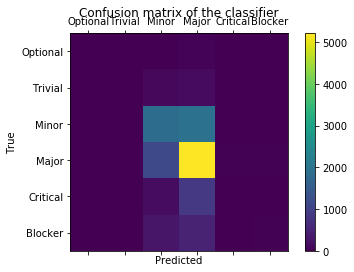

In [216]:
%matplotlib inline
# Taken from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt

labels = ['Optional', 'Trivial', 'Minor', 'Major', 'Critical', 'Blocker']
#cm = confusion_matrix(y_test, pred, labels)
#print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Using another dataset

In [217]:
dataset = pd.read_csv("JIRA_OPEN_DATA_ZOOKEEPER.csv")

In [218]:
dataset.head()

id                  created  \
0  16037  2011-06-16 22:07:44.375   
1  16615  2009-08-07 08:57:50.287   
2  16189  2010-11-20 06:12:26.124   
3  16616   2009-08-07 06:11:42.25   
4  16934  2008-10-07 04:50:15.001   

                                         description             key priority  \
0  traverseNode in DataTree will never actually t...  ZOOKEEPER-1097  Blocker   
1  when calling the asynchronous version of creat...   ZOOKEEPER-502    Major   
2  test -e FILENAME is not support on /bin/sh in ...   ZOOKEEPER-937    Major   
3  It timed out according to the console output:h...   ZOOKEEPER-501    Major   
4                fast leader election test failing .   ZOOKEEPER-178    Major   

     project project_name repositoryname resolution                 resolved  \
0  ZOOKEEPER    ZooKeeper            ASF      Fixed  2011-06-27 07:30:59.505   
1  ZOOKEEPER    ZooKeeper            ASF      Fixed  2010-01-27 07:19:07.334   
2  ZOOKEEPER    ZooKeeper            ASF      Fixed  2010-12-08 03:02:17.059   
3  ZOOKEEPER    ZooKeeper            ASF      Fixed  2009-08-08 05:03:30.561   
4  ZOOKEEPER    ZooKeeper            ASF      Fixed  2008-10-11 07:16:55.237   

   status                                              title type  \
0  Closed  Quota is not correctly rehydrated on snapshot ...  Bug   
1  Closed  bookkeeper create calls completion too many times  Bug   
2  Closed           test -e not available on solaris /bin/sh  Bug   
3  Closed                    CnxManagerTest failed on hudson  Bug   
4  Closed                                          FLE test.  Bug   

                   updated  votes  watchers  assignee_id  reporter_id  
0  2011-11-24 03:22:06.217      0         0       7832.0         7832  
1  2010-03-27 01:24:56.283      0         0       7750.0         7829  
2  2011-11-24 03:21:59.751      0         0       8219.0         8219  
3  2009-09-06 06:36:20.729      0         0       7750.0         7750  
4   2008-10-26 09:10:43.46      0         0       7750.0         7827

In [219]:
df = dataset[["title", "description", "priority"]]
df['features'] = df['title'] + " " + df['description']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [220]:
df.head()

title  \
0  Quota is not correctly rehydrated on snapshot ...   
1  bookkeeper create calls completion too many times   
2           test -e not available on solaris /bin/sh   
3                    CnxManagerTest failed on hudson   
4                                          FLE test.   

                                         description priority  \
0  traverseNode in DataTree will never actually t...  Blocker   
1  when calling the asynchronous version of creat...    Major   
2  test -e FILENAME is not support on /bin/sh in ...    Major   
3  It timed out according to the console output:h...    Major   
4                fast leader election test failing .    Major   

                                            features  
0  Quota is not correctly rehydrated on snapshot ...  
1  bookkeeper create calls completion too many ti...  
2  test -e not available on solaris /bin/sh test ...  
3  CnxManagerTest failed on hudson It timed out a...  
4      FLE test. fast leader election test failing .

In [221]:
num_rows = df.shape[0]
print(num_rows)

447


In [222]:
labels1 = []
features1 = []
for i in range(num_rows):
    labels1.append(orig_labels[df.iloc[i].priority])
    f = df.iloc[i].features
    f = f.strip('\n')
    f = f.strip('\t')    
    features1.append(f)

#print(features1[1:10])

In [223]:
payload1 = {"instances" : features1}

In [224]:
response = text_classifier.predict(json.dumps(payload1))

predictions1 = json.loads(response)
#print(json.dumps(predictions1, indent=2))

In [225]:
# create confustion matrix
cm1 = np.zeros((6,6), dtype=int)

In [226]:
i = 0
for l in labels1:
    actual = l
    predicted = predictions1[i]['label'][0]
    #print(actual + "," + predicted)
    act_idx = label_map[actual]
    pre_idx = label_map[predicted]
    #print(act_idx, pre_idx)
    cm1[act_idx, pre_idx] += 1
    i = i + 1
    
print(cm1)

[[  0   0   0   0   0   0]
 [  0   1   5   7   0   0]
 [  0   0   9  61   0   0]
 [  0   0  22 202   0   0]
 [  0   0   4  59   0   0]
 [  0   0   3  73   1   0]]


In [227]:
print("label precision recall")
for label in range(6):
    print(f"{label:5d} {precision(label, cm1):9.3f} {recall(label, cm1):6.3f}")

print("\n")
print("precision total:", precision_macro_average(cm1))
print("recall total:", recall_macro_average(cm1))
print("accuracy:", accuracy(cm1))

label precision recall
    0       nan    nan
    1     1.000  0.077
    2     0.209  0.129
    3     0.502  0.902
    4     0.000  0.000
    5       nan  0.000


precision total: nan
recall total: nan
accuracy: 0.4742729306487696


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in long_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in long_scalars


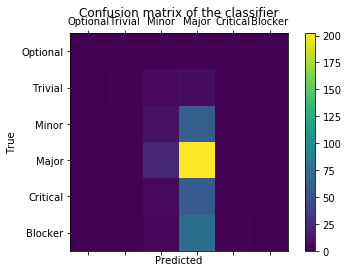

In [228]:
%matplotlib inline
# Taken from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt

labels = ['Optional', 'Trivial', 'Minor', 'Major', 'Critical', 'Blocker']
#cm = confusion_matrix(y_test, pred, labels)
#print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm1)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Stop / Close the Endpoint (Optional)
Finally, we should delete the endpoint before we close the notebook if we don't need to keep the endpoint running for serving realtime predictions.

In [229]:
sess.delete_endpoint(text_classifier.endpoint)